# 📂 Capítulo 4 - Técnicas de Validación

La validación de modelos de **detección de anomalías en series temporales** plantea retos adicionales frente a la validación en datos convencionales. La razón principal es la **naturaleza temporal de las señales**, que introduce dependencias y restricciones que impiden aplicar directamente técnicas clásicas como la *Cross-Validation aleatoria* o el *Bootstrap*.  

En problemas tradicionales, las observaciones suelen considerarse independientes e intercambiables. En cambio, en series temporales:

- ⏱️ **Dependencia temporal** → lo que ocurre en el instante \(t\) depende de lo que ocurrió en \(t-1\).  
- ⚠️ **Riesgo de fuga de información (*data leakage*)** → si se entrena un modelo con observaciones futuras y se valida en el pasado, los resultados carecen de validez práctica.  
- 📉 **Escasez y desbalance** → las anomalías son poco frecuentes en comparación con el comportamiento normal.  
- 📏 **Naturaleza de las anomalías** → a menudo se presentan como **intervalos** prolongados, no solo como puntos aislados.  

---

## 🎯 Objetivos de la validación temporal

En consecuencia, la validación en series temporales exige:

1. **Métricas específicas**, que midan no solo la detección puntual, sino también la cobertura de intervalos y, especialmente, la utilidad práctica de las detecciones tempranas.  
2. **Protocolos de validación temporales**, que respeten el orden cronológico de los datos y eviten cualquier mezcla entre pasado y futuro.  

---

## 📌 Estructura de este capítulo

A lo largo de este capítulo se presentan:  

- El enfoque **NAB (Numenta Anomaly Benchmark)** como referencia principal para **definir métricas de evaluación**, ya que:  
  - Premia detecciones tempranas dentro de una ventana de anomalía.  
  - Penaliza detecciones falsas fuera de las ventanas.  
  - Ofrece una función de puntuación continua y perfiles de aplicación para distintos escenarios de uso.  

- Como complemento, se introduce también el enfoque de **Range-Based Validation**, que extiende la evaluación a anomalías representadas como intervalos de distinta duración, unificando métricas clásicas con escenarios más generales.  

- Dos estrategias fundamentales para la **validación temporal de modelos**:  
  - **TSCV con ventanas rodantes (*Expanding Window*)**, aplicable a modelos que no permiten reentrenamiento incremental.  
  - **Rolling-Origin Evaluation**, adecuada para modelos capaces de actualizarse de manera progresiva.  

Con esta combinación de métricas y protocolos, se construye un marco sólido y realista para comparar el rendimiento de distintos detectores de anomalías en series temporales.

---

## 4.1 Enfoques para la definición de métricas

### 4.1.1 Numenta Anomaly Benchmark (NAB)

El benchmark **NAB (Numenta Anomaly Benchmark)** se ha convertido en un estándar de referencia en la evaluación de modelos de detección de anomalías en series temporales. Su principal aportación consiste en definir un sistema de **puntuación dinámico y continuo** que refleja de manera realista el valor de las detecciones en función de **cuándo** se producen.

---

#### Principios del NAB
1. **Recompensa a las detecciones tempranas**  
   - Si una alarma ocurre en la parte inicial de la ventana de anomalía (o incluso ligeramente antes, dentro de la extensión definida), se obtiene una puntuación cercana a la máxima.  
   - Cuanto más se acerque la detección al final de la ventana, menor será la recompensa.

2. **Penalización de las falsas alarmas**  
   - Si el sistema genera detecciones fuera de las ventanas (extendidas) se resta puntuación.  
   - Cuanto más lejos de la anomalía real, más fuerte la penalización.

3. **Función de puntuación continua (`scaledSigmoid`)**  
   - En lugar de un esquema binario (acierto/error), se aplica una función logística escalada que varía de $+1$ a $-1$ según la posición relativa de la detección en la ventana.  
   - Esto permite medir **tempraneidad**, **retraso** y distinguir entre errores cercanos o muy alejados.

---

#### Construcción de las ventanas
Cada anomalía real anotada $[t_{\text{start}}, t_{\text{end}}]$ se **extiende** antes y después para definir la ventana de scoring:

$$
W = [\, t_{\text{start}} - \delta, \; t_{\text{end}} + \delta \,]
$$

donde $\delta$ se calcula como:

$$
\delta = \min\Big(\max(\text{min\_ext}, \; \text{ratio}\cdot |W_{\text{real}}|), \; \text{max\_ext}\Big)
$$

con:
- `ratio` = proporción de extensión respecto a la duración de la anomalía,  
- `min_ext` = extensión mínima,  
- `max_ext` = extensión máxima (p.ej. 10% de la serie).

---

#### Fórmula de la puntuación

Sea una detección en el instante $t$ y la ventana $[t_{\text{start}}, t_{\text{end}}]$.  
Se calcula la **posición relativa**:

$$
\text{pos}(t) = -\frac{t_{\text{end}} - t + 1}{|W|}
$$

- En el **inicio de la ventana**: $\text{pos} = -1.0$  
- En el **final de la ventana**: $\text{pos} \approx 0.0$  
- **Fuera de la ventana**: $\text{pos} > 0$

La recompensa se obtiene con la función `scaledSigmoid`:

$$
s(t) = A_{TP} \cdot 
\begin{cases}
-1, & \text{si } \text{pos}(t) > 3 \\\\
2 \cdot \sigma(-5 \cdot \text{pos}(t)) - 1, & \text{en otro caso}
\end{cases}
$$

donde $\sigma(x) = \tfrac{1}{1+e^{-x}}$ es la sigmoide estándar.

- **Detección temprana** ($\text{pos}=-1$) $\;\Rightarrow\;$ $s(t) \approx +0.986 \cdot A_{TP}$  
- **Final de ventana** ($\text{pos}=0$) $\;\Rightarrow\;$ $s(t)=0$  
- **Después de la ventana** ($\text{pos}>0$) $\;\Rightarrow\;$ valores negativos, hasta $-A_{TP}$

Los falsos positivos y negativos se penalizan de forma fija:

$$
s_{\mathrm{FP}} = -A_{FP}, \qquad s_{\mathrm{FN}} = -A_{FN}
$$

---

#### Normalización

El score bruto es:

$$
S_{\text{raw}} = \sum_i s_i
$$

y se normaliza respecto a dos detectores de referencia:

$$
S_{\text{norm}} = 100 \times \frac{S_{\text{raw}} - S_{\text{null}}}{S_{\text{perfect}} - S_{\text{null}}}
$$

- $S_{\text{perfect}}$: detector ideal (detecta todas las anomalías justo al inicio, sin FP).  
- $S_{\text{null}}$: detector que no detecta nada.  

De esta forma, el NAB score final siempre se encuentra entre 0 y 100.

---




#### Ejemplo ilustrativo con Python

A continuación, un pequeño ejemplo para entender cómo funciona este sistema. Creamos una serie temporal con un intervalo de anomalía y simulamos distintas detecciones para ver cómo se calcula el puntaje de acuerdo al NAB:

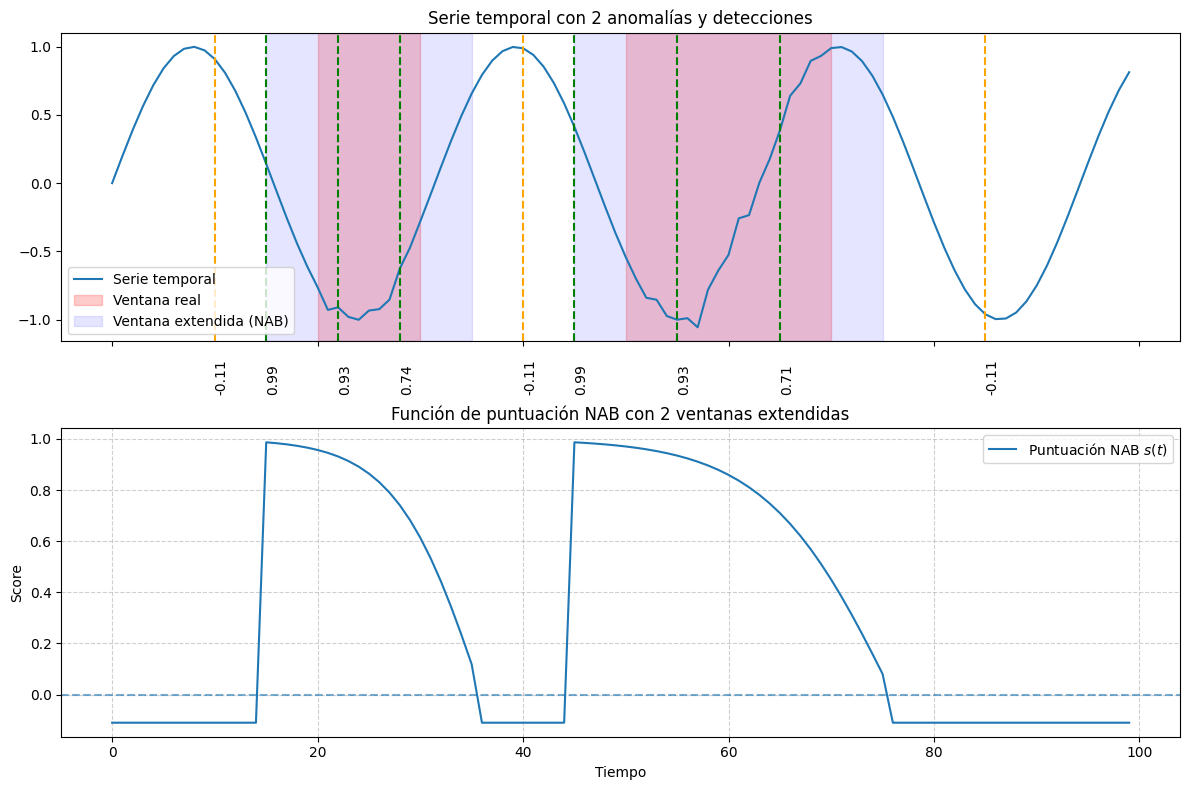

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from modelos.validation_metrics import nab_reward, extend_window

# Configuración base
n = 100
anomalies = [(20, 30), (50, 70)]  # dos anomalías reales

# Extender ventanas al estilo NAB
extended_anomalies = [extend_window(s, e, n, ratio=0.2, min_ext=5) for (s, e) in anomalies]

# Perfiles (NAB estándar)
A_TP = 1.0
A_FP = 0.11
A_FN = 1.0

# --- Simulamos detecciones ---
detections = [10, 15, 22, 28, 40, 45, 55, 65, 85]  # algunas en cada zona

def score_detection(t):
    # Si está dentro de alguna ventana extendida → usar nab_reward
    for (s_ext, e_ext) in extended_anomalies:
        if s_ext <= t <= e_ext:
            return nab_reward(t, s_ext, e_ext, A_TP=A_TP)
    # Si está fuera de todas → penalización FP
    return -A_FP

scores = [score_detection(d) for d in detections]

# --- Serie con anomalías simuladas ---
time = np.arange(0, n)
series = np.sin(time/5)

for (s, e) in anomalies:
    length = e - s
    noise = np.random.normal(0, 0.1, length)
    gaussian_mask = np.exp(-0.5 * ((np.linspace(-2, 2, length))**2))
    series[s:e] += noise * gaussian_mask

# --- Figura ---
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Subplot 1: serie + ventanas + detecciones
axes[0].plot(time, series, label="Serie temporal")
for (s, e) in anomalies:
    axes[0].axvspan(s, e, color="red", alpha=0.2, label="Ventana real" if s == anomalies[0][0] else "")
for (s_ext, e_ext) in extended_anomalies:
    axes[0].axvspan(s_ext, e_ext, color="blue", alpha=0.1, label="Ventana extendida (NAB)" if s_ext == extended_anomalies[0][0] else "")

for d, s in zip(detections, scores):
    axes[0].axvline(d, color=("green" if s > 0 else "orange"), linestyle="--")
    axes[0].text(d, series.min() - 0.5, f"{s:.2f}", rotation=90, va="bottom")

axes[0].legend()
axes[0].set_title("Serie temporal con 2 anomalías y detecciones")

# Subplot 2: curva de puntuación NAB en todo el rango temporal
t_vals = np.arange(0, n)
def piecewise_score(t):
    for (s_ext, e_ext) in extended_anomalies:
        if s_ext <= t <= e_ext:
            return nab_reward(t, s_ext, e_ext, A_TP=A_TP)
    return -A_FP

s_vals = [piecewise_score(t) for t in t_vals]

axes[1].plot(t_vals, s_vals, label="Puntuación NAB $s(t)$")
axes[1].axhline(0.0, linestyle="--", alpha=0.6)
axes[1].set_title("Función de puntuación NAB con 2 ventanas extendidas")
axes[1].set_xlabel("Tiempo")
axes[1].set_ylabel("Score")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


**Conclusión de la gráfica**  

La ilustración muestra cómo la métrica NAB asigna puntuaciones a las detecciones en función de su posición relativa respecto a las ventanas de anomalía:  

- **Antes o fuera de las ventanas extendidas** → cada detección se penaliza con un valor fijo negativo (en este ejemplo, $-0.11$).  
- **En el inicio de una ventana de anomalía** → la detección recibe casi la máxima recompensa posible (≈ $+1$), reflejando un acierto muy temprano.  
- **Dentro de la ventana** → la recompensa decrece suavemente conforme la detección se acerca al final, hasta alcanzar $0$ en el borde derecho.  
- **Regla de conteo** → si hay varias detecciones en la misma ventana, **solo la primera** se considera para el cálculo de la métrica; las demás no aportan valor adicional.  

De esta manera, NAB pondera no solo si se detecta una anomalía, sino también **cuándo se detecta**, premiando la anticipación y castigando las falsas alarmas.








### 4.1.2 Curva ROC y métrica ROC-AUC

Otra de las métricas clásicas en problemas de detección de anomalías y clasificación binaria es el **área bajo la curva ROC (ROC-AUC)**.  
Para comprenderla, conviene desglosar primero los dos elementos que la componen:

---

#### Curva ROC (Receiver Operating Characteristic)

La **curva ROC** representa gráficamente la relación entre:

- **True Positive Rate (TPR o Recall):** proporción de anomalías correctamente detectadas.  
- **False Positive Rate (FPR):** proporción de eventos normales clasificados erróneamente como anomalías.  

A medida que se varía el **umbral de decisión** aplicado sobre la puntuación continua $y_{\text{score}}$, se obtiene un punto distinto en este espacio TPR–FPR.  
La curva ROC es, por tanto, el recorrido que describe el modelo al barrer todos los umbrales posibles.

---

#### Área bajo la curva (AUC)

El término **AUC (Area Under the Curve)** hace referencia al área bajo *una* curva.  
En la práctica, salvo que se especifique lo contrario, se sobreentiende que se trata del área bajo la curva ROC.  

Este valor puede interpretarse como la probabilidad de que el modelo asigne una puntuación mayor a una instancia positiva (anómala) que a una instancia negativa (normal):

- $AUC = 1.0$ → separación perfecta.  
- $AUC = 0.5$ → el modelo no distingue, equivalente a clasificar al azar.  
- $AUC < 0.5$ → peor que el azar, indicando que el modelo invierte sistemáticamente las predicciones.

---

#### ROC-AUC como métrica de evaluación

El término **ROC-AUC** se utiliza de manera explícita para referirse al **área bajo la curva ROC**.  
De esta forma se evita confundirlo con otras variantes de AUC (por ejemplo, el área bajo la curva de precisión-recall).  

El **ROC-AUC** proporciona una medida **independiente del umbral** y muy útil para comparar detectores con salidas continuas.  

En este proyecto se emplea como métrica estándar para evaluar modelos de detección de anomalías, ya que captura tanto la capacidad de discriminación como la robustez frente a diferentes umbrales de decisión.  

En resumen, la métrica **ROC-AUC** nos permite evaluar la capacidad de un modelo de **ordenar correctamente las instancias anómalas por encima de las normales**, independientemente del umbral concreto elegido.


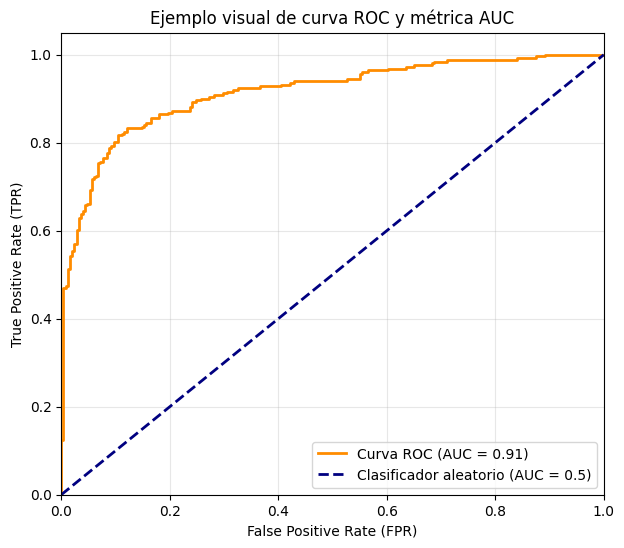

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Generamos un dataset sintético (binario)
X, y = make_classification(
    n_samples=500, n_features=10, n_informative=5,
    n_redundant=2, n_classes=2, random_state=42
)

# 2. Entrenamos un modelo simple
clf = LogisticRegression()
clf.fit(X, y)

# 3. Obtenemos las probabilidades predichas
y_score = clf.predict_proba(X)[:, 1]

# 4. Calculamos la curva ROC y el AUC
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = roc_auc_score(y, y_score)

# 5. Graficamos
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--",
         label="Clasificador aleatorio (AUC = 0.5)")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Ejemplo visual de curva ROC y métrica AUC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


En la gráfica anterior se muestra un ejemplo de la **curva ROC** obtenida por un clasificador sencillo.  
La línea azul discontinua representa la curva esperada para un **clasificador aleatorio teórico**, que sirve como referencia base: cualquier modelo útil debe situarse claramente por encima de esta diagonal.


### 4.1.3 Métricas de precisión, recall y cobertura de ventanas

Además de métricas más sofisticadas como el NAB o el ROC-AUC, en este proyecto también se tendrán en cuenta indicadores clásicos de la evaluación en clasificación binaria, junto con una métrica específica para intervalos:

- **Precisión (precision):** mide la proporción de detecciones que realmente eran anomalías, es decir, cuántas de las alarmas levantadas por el modelo resultaron correctas.  
- **Recall (sensibilidad):** mide la proporción de anomalías reales que el modelo logró detectar, es decir, su capacidad para no dejar escapar anomalías.  
- **Cobertura de ventanas (window coverage):** mide qué porcentaje de los intervalos anómalos contienen al menos una detección, reflejando la capacidad del modelo para cubrir anomalías extendidas en el tiempo.  

Estas métricas aportan una visión intuitiva y complementaria, mostrando de manera más directa **cuánto acierta el modelo, cuánto falla y hasta qué punto logra cubrir intervalos completos de anomalía**.


## 4.2 Estrategias de Validación en Series Temporales

### 4.2.1 Time Series Cross-Validation (TSCV) con *Expanding Window*

La validación con **ventana creciente** (*expanding/growing window*) evalúa un modelo de serie temporal haciendo que el **conjunto de entrenamiento crezca con el tiempo**. En cada iteración (split), se entrena con **todo el histórico disponible hasta un punto** y se valida inmediatamente **después** de ese punto, respetando siempre la causalidad.

---

#### Definición formal

Sea la serie temporal $\{(x_t, y_t)\}_{t=1}^T$, donde $y_t$ puede existir solo para evaluación. Parámetros:

- $L_{\text{train,min}}$: tamaño **mínimo inicial** del entrenamiento.  
- $L_{\text{val}}$: longitud de la **ventana de validación**.  
- $G$: **gap/embargo** entre entrenamiento y validación.  
- $S$: **desplazamiento** (*step*) entre *splits*.  

Sea $t^{(j)}$ el **final del entrenamiento** en el split $j$. Se define recursivamente:

$$
t^{(0)} = L_{\text{train,min}}, 
\qquad
t^{(j+1)} = t^{(j)} + S
$$

Para cada split $j = 0,1,\dots,J$:

- Índices de **entrenamiento** (creciente):
  $$
  \mathcal{I}^{(j)}_{\text{train}} = [\, 1,\; t^{(j)} \,]
  $$
- **Gap/embargo**:
  $$
  \mathcal{I}^{(j)}_{\text{gap}} = [\, t^{(j)} + 1,\; t^{(j)} + G \,]
  $$
- Índices de **validación**:
  $$
  \mathcal{I}^{(j)}_{\text{val}} = [\, t^{(j)} + G + 1,\; t^{(j)} + G + L_{\text{val}} \,]
  $$

Número de *splits* válidos:

$$
J + 1 \;=\; \left\lfloor \frac{T - L_{\text{train,min}} - G - L_{\text{val}}}{S} \right\rfloor + 1
$$

---

#### Regla esencial: **sin fuga de información**

- **Ajustar** (*fit*) cualquier transformación **exclusivamente** en $\mathcal{I}^{(j)}_{\text{train}}$ y **aplicarla** (*transform/predict*) en $\mathcal{I}^{(j)}_{\text{val}}$.  
- Esto incluye: imputación, *scaling*, creación de *lags*/ventanas, selección de variables, PCA, calibración de umbrales, etc.  
- El **embargo** $G$ purga dependencias entre el último punto de *train* y los primeros de *val* (p. ej., por *lags* o suavizados).

---

#### Procedimiento por split $j$

1. **Preparación y *fit-on-train***  
   - Construir el *pipeline* (imputación, escalado, ingeniería de *features* con lags/ventanas) y **ajustarlo solo** con $x_t$ para $t \in \mathcal{I}^{(j)}_{\text{train}}$.  
   - Entrenar el modelo con ese conjunto creciente. Si el modelo lo permite, se puede **actualizar incrementalmente** en lugar de reentrenar desde cero.

2. **Predicción en validación**  
   - Producir puntajes/alertas para $t \in \mathcal{I}^{(j)}_{\text{val}}$, **sin acceso a datos futuros**.

3. **Evaluación de métricas**  
   - Calcular las métricas definidas (p. ej., NAB) **solo** con las etiquetas/ventanas de anomalía dentro de $\mathcal{I}^{(j)}_{\text{val}}$.  
   - Guardar el resultado del split (y, si aplica, contadores de eventos evaluados).

---

#### Elección de hiperparámetros y umbrales

- Realizar la selección con **técnicas internas** que respeten el tiempo (p. ej., una TSCV **interna** dentro de $\mathcal{I}^{(j)}_{\text{train}}$) o reglas fijas calibradas **solo** en *train*.  
- Evitar usar información de $\mathcal{I}^{(j)}_{\text{val}}$ para fijar umbrales (sería fuga).

---

#### Agregación de resultados

Sea $M^{(j)}$ la métrica del split $j$. Formas habituales:

- **Media simple**:  
  $$
  \overline{M} \;=\; \frac{1}{J+1} \sum_{j=0}^{J} M^{(j)}
  $$
- **Media ponderada** (p. ej., por número de ventanas de anomalía $n^{(j)}$ evaluadas en el split):  
  $$
  \overline{M}_{\text{pond}} \;=\; \frac{\sum_{j=0}^{J} n^{(j)}\, M^{(j)}}{\sum_{j=0}^{J} n^{(j)}}
  $$

Reportar también **dispersión** (desviación estándar o percentiles) entre *splits*.

---

#### Elección práctica de $L_{\text{train,min}}, L_{\text{val}}, G, S$

- $L_{\text{train,min}}$: cubrir al menos **una estacionalidad completa** para estabilizar el primer *fit*.  
- $L_{\text{val}}$: suficientemente largo para **observar anomalías** representativas.  
- $G$:  
  $$
  G \;\ge\; \max\{\, \text{máx. lag en *features*},\ \text{longitud de suavizado},\ \tfrac{1}{2}\,|W_i| \,\}
  $$
- $S$: frecuencia con la que se abre una nueva validación; valores menores dan **más *splits*** y una curva temporal de rendimiento más densa.

---

#### Buenas prácticas

- **Alineación temporal** estricta entre *features* con lags y sus etiquetas.  
- **Embargo** suficiente si hay *look-ahead* implícito (p. ej., agregaciones que “miran” hacia delante).  
- **Consistencia del *pipeline***: fijar semillas, registrar versiones y parametrización por split.  
- En detección no supervisada, la **calibración del umbral** debe hacerse solo con *train* (o una TSCV interna), nunca con *val*.

---


In [7]:
# Expanding (Growing) Window TSCV - Señal fija, sin GAP, con slider + play
# Requisitos: ipywidgets

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Play, IntSlider, jslink, HBox, VBox, Output, Label
from IPython.display import display, clear_output

# ---------------------------
# Parámetros del ejemplo
# ---------------------------
T = 240            # longitud total de la serie (índices 0..T-1)
MIN_TRAIN = 60     # tamaño mínimo inicial del train
L_val = 30         # longitud de la validación
S = 30             # desplazamiento entre splits (crecimiento por iteración)

# ---------------------------
# Construcción de splits (SIN GAP)
# Train: [0 .. t_j], Val: [t_j+1 .. t_j+L_val]
# ---------------------------
splits = []  # (train_end, val_start, val_end)
t_j = MIN_TRAIN - 1
while t_j + L_val < T:
    tr_e  = t_j
    va_s  = t_j + 1
    va_e  = t_j + L_val
    splits.append((tr_e, va_s, va_e))
    t_j += S

N = len(splits)

# ---------------------------
# Serie sintética (señal FIJA)
# ---------------------------
np.random.seed(7)
time = np.arange(T)
series = np.sin(time/12) + 0.15*np.random.randn(T)
ymin, ymax = float(series.min()), float(series.max())
ymargin = 0.15 * (ymax - ymin) if ymax > ymin else 0.5
y_bottom, y_top = ymin - ymargin, ymax + ymargin

# ---------------------------
# Función de pintado por split (la señal NO se mueve)
# ---------------------------
out = Output()

def plot_split(i):
    with out:
        clear_output(wait=True)
        tr_e, va_s, va_e = splits[i]

        fig, ax = plt.subplots(figsize=(10, 3.6))
        # Serie completa (fija)
        ax.plot(time, series, linewidth=1.4, label="Serie temporal")

        # Sombreado de TRAIN (creciente) y VALIDACIÓN (fija en longitud)
        ax.axvspan(0, tr_e, alpha=0.12, label="Train (creciente)")
        ax.axvspan(va_s, va_e, alpha=0.18, label="Val")

        # Líneas guía (fronteras)
        ax.axvline(tr_e, linestyle="--")
        ax.axvline(va_s, linestyle=":")
        ax.axvline(va_e, linestyle=":")

        # Ejes FIJOS
        ax.set_xlim(0, T-1)
        ax.set_ylim(y_bottom, y_top)

        # Título y leyenda
        ax.set_title(
            f"TSCV (Expanding Window) — Split {i+1}/{N}  |  fit: [0..{tr_e}]  →  predict: [{va_s}..{va_e}]"
        )
        ax.set_xlabel("Tiempo (índice)")
        ax.legend(loc="upper left")
        plt.tight_layout()
        plt.show()

# ---------------------------
# Widgets: Play + Slider
# ---------------------------
play = Play(interval=600, value=0, min=0, max=N-1, step=1)
slider = IntSlider(value=0, min=0, max=N-1, step=1, description="Split")
jslink((play, 'value'), (slider, 'value'))
slider.observe(lambda ch: plot_split(ch['new']), names='value')

controls = HBox([Label("Recorrer splits:"), play, slider])
display(VBox([controls, out]))

# primer render
plot_split(0)



### 4.2.2 Walk-Forward con Reentrenamiento **Incremental por Bloques** (Single-Block Update)

Este esquema evalúa modelos que permiten **actualización incremental** a medida que avanza el tiempo. La idea clave es que, en cada iteración, el modelo **solo se entrena/actualiza con el bloque actual** y se valida en el **bloque inmediatamente siguiente**. Tras evaluar, el bloque validado pasa a ser el **nuevo bloque de entrenamiento** para la siguiente iteración. **No se usa gap** entre entrenamiento y validación.

---

#### Definición formal

Sea la serie $\{(x_t,y_t)\}_{t=1}^T$ y una partición temporal en **bloques contiguos y no solapados**:
$$
\mathcal{B}=\{B_0,B_1,\dots,B_K\}, \quad
B_j = [\tau_j^{\text{ini}},\,\tau_j^{\text{fin}}], \quad
\bigcup_{j=0}^{K} B_j = [1,T],\; B_j\cap B_{j'}=\varnothing\ (j\neq j').
$$

- $B_0$: **bloque inicial de entrenamiento** (tamaño mínimo suficiente).
- Para $j=0,1,\dots,K-1$, la **iteración $j$** se define como:
  - **Entrenamiento/actualización** (solo el bloque actual):
    $$
    \mathcal{I}^{(j)}_{\text{train}} = B_j
    $$
  - **Validación** (bloque inmediatamente posterior):
    $$
    \mathcal{I}^{(j)}_{\text{val}} = B_{j+1}
    $$

---

#### Protocolo por iteración $j$

1. **Ajuste de hiperparámetros (solo con $B_j$)**  
   Seleccionar $\theta^{(j)}$ **exclusivamente** con datos de $B_j$ (p. ej., con una TSCV interna sobre $B_j$):
   $$
   \theta^{(j)} \leftarrow \underset{\theta}{\arg\max}\ \text{Métrica}\big(\text{model}(x;\theta)\ \text{en}\ B_j\big)
   $$

2. **Entrenamiento/Actualización con $B_j$**  
   Entrenar o **actualizar incrementalmente** el modelo usando **solo** $B_j$:
   $$
   \hat{f}^{(j)} \leftarrow \text{fit/update}\big(x_t,y_t;\ \theta^{(j)}\big)\ \ \text{para } t\in B_j
   $$

3. **Validación out-of-sample en $B_{j+1}$**  
   Evaluar **sin mirar datos posteriores**:
   $$
   M^{(j)} = \text{Métrica}\Big(\hat{f}^{(j)}(x_t),\, y_t\Big)\ \ \text{para } t\in B_{j+1}
   $$

4. **Avance (refit para la siguiente iteración)**  
   Tras evaluar $B_{j+1}$, ese bloque pasa a ser el **nuevo bloque de entrenamiento**:
   - Para preparar la iteración $j+1$, puedes **recalibrar** hiperparámetros $\theta^{(j+1)}$ usando **solo** $B_{j+1}$ (sin mirar $B_{j+2}$) y **actualizar** el modelo con $B_{j+1}$.

> **Sin fuga de información:** cualquier `fit` (imputación, *scaling*, lags/ventanas, PCA, selección de variables, umbrales e hiperparámetros) debe realizarse **únicamente** con $B_j$ antes de evaluar en $B_{j+1}$. La evaluación en $B_{j+1}$ no puede influir en el modelo **hasta después** de reportar $M^{(j)}$.

---

#### Agregación de resultados

Sea $M^{(j)}$ la métrica obtenida al validar en $B_{j+1}$. El desempeño global se resume como:

- **Media simple**:
  $$
  \overline{M}=\frac{1}{K}\sum_{j=0}^{K-1} M^{(j)}
  $$
- **Media ponderada** (p. ej., por número de eventos evaluados $n^{(j)}$ en $B_{j+1}$):
  $$
  \overline{M}_{\text{pond}}=\frac{\sum_{j=0}^{K-1} n^{(j)}\,M^{(j)}}{\sum_{j=0}^{K-1} n^{(j)}}
  $$

Se recomienda reportar también la **dispersión** (desviación estándar, IQR o percentiles) de $\{M^{(j)}\}$.

---

#### Elección práctica de bloques

- $|B_0|$ (entrenamiento inicial): cubrir **al menos una estacionalidad** para un primer ajuste estable.  
- $|B_{j>0}|$ (bloques de validación/actualización): elegir según el **horizonte operativo** (p. ej., 1 semana/mes).  
- **Sin gap:** $\mathcal{I}^{(j)}_{\text{val}}$ empieza inmediatamente tras $\mathcal{I}^{(j)}_{\text{train}}$.

> La gestión/limpieza de *outliers* después de cada validación (si procede) se detalla en un apartado posterior y puede intercalarse entre los pasos 3 y 4.


In [ ]:
# Walk-Forward con reentrenamiento por bloque (single-block update)
# Iteración j: Train/Update = B_j  ->  Validación = B_{j+1}
# Requisitos: ipywidgets (pip install ipywidgets)

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Play, IntSlider, jslink, HBox, VBox, Output, Label
from IPython.display import display, clear_output

# ---------------------------
# Parámetros
# ---------------------------
T         = 360   # longitud total de la serie (0..T-1)
L_train0  = 60    # tamaño del bloque inicial B0 (primera vez que se entrena)
L_blk     = 30    # longitud de cada bloque sucesivo (B1, B2, ...)

# ---------------------------
# Bloques contiguos sin solape: B0, B1, B2, ...
# ---------------------------
blocks = []
# B0: bloque inicial de entrenamiento
blocks.append((0, L_train0 - 1))
# B1..BK: bloques de validación/actualización
start = L_train0
while start + L_blk <= T:
    blocks.append((start, start + L_blk - 1))
    start += L_blk

# Número de iteraciones válidas (j tal que existe B_{j+1})
# En j: train/update = B_j, validation = B_{j+1}
N_iters = max(0, len(blocks) - 1)

# ---------------------------
# Serie sintética (señal FIJA)
# ---------------------------
np.random.seed(7)
time = np.arange(T)
series = np.sin(time/18) + 0.15*np.random.randn(T)
ymin, ymax = float(series.min()), float(series.max())
ymargin = 0.15 * (ymax - ymin) if ymax > ymin else 0.5
y_bottom, y_top = ymin - ymargin, ymax + ymargin

# ---------------------------
# Pintado por iteración
# ---------------------------
out = Output()

def plot_iter(j):
    """
    Iteración j:
      - Train/Update = B_j  (solo ese bloque se usa para entrenar/actualizar el modelo)
      - Validación   = B_{j+1}
    Después de validar, el modelo absorbe B_{j+1} y se pasa a j+1.
    """
    with out:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 3.9))

        # Serie completa (no se mueve)
        ax.plot(time, series, linewidth=1.4, label="Serie temporal")

        # Bloques Train/Update y Validación del paso actual
        tr_s, tr_e = blocks[j]         # B_j
        va_s, va_e = blocks[j+1]       # B_{j+1}

        # Sombreado: el bloque usado para entrenar/actualizar en esta iteración
        ax.axvspan(tr_s, tr_e, alpha=0.18, label=f"Train/Update = B{j}")
        # Sombreado: el bloque de validación del paso actual
        ax.axvspan(va_s, va_e, alpha=0.26, label=f"Validación = B{j+1}")

        # Líneas guía de frontera de cada bloque + etiqueta Bk arriba
        for k, (a, b) in enumerate(blocks):
            ax.axvline(a, linestyle=":", linewidth=0.9)
            ax.text((a + b) / 2, y_top, f"B{k}", ha="center", va="bottom", fontsize=8)

        # Ejes fijos
        ax.set_xlim(0, T - 1)
        ax.set_ylim(y_bottom, y_top)

        # Título explicativo (ciclo que querías)
        ax.set_title(
            f"Walk-Forward (single-block update) — Iteración {j+1}/{N_iters}\n"
            f"Entrena con B{j}  →  Valida en B{j+1}"
        )
        ax.set_xlabel("Tiempo (índice)")
        ax.legend(loc="upper left")
        plt.tight_layout()
        plt.show()

# ---------------------------
# Widgets: Play + Slider
# ---------------------------
if N_iters == 0:
    print("No hay bloques suficientes. Aumenta T o ajusta L_train0/L_blk.")
else:
    play = Play(interval=700, value=0, min=0, max=N_iters-1, step=1)
    slider = IntSlider(value=0, min=0, max=N_iters-1, step=1, description="Iteración")
    jslink((play, 'value'), (slider, 'value'))

    slider.observe(lambda ch: plot_iter(ch['new']), names='value')

    display(VBox([HBox([Label("Recorrer:"), play, slider]), out]))
    plot_iter(0)


## 4.3 Preprocesamiento: entrenamiento solo con datos “normales” (limpieza con filtro de **Hampel** sobre el residuo)

Para que las dos estrategias de validación anteriores (TSCV y Walk-Forward por bloques) sean **fiables**, el modelo debe **entrenarse únicamente con datos “normales”**.  
En la práctica **no conocemos a priori** qué puntos del conjunto de entrenamiento (o de los bloques que vamos incorporando) contienen anomalías.  
La solución adoptada es **limpiar** cada bloque **antes** de usarlo para entrenar/reentrenar el modelo, aplicando un **único método robusto y ampliamente usado**:

> **Filtro de Hampel aplicado sobre el *residuo*** (tras separar tendencia y estacionalidad).

---

### 4.3.1 Idea y motivación

- Separar la señal en **tendencia** $T_t$, **estacionalidad** $S_t$ y **residuo** $R_t$.  
- Detectar outliers **locales** en el residuo con **mediana** y **MAD** (no sensibles a picos), y **reemplazarlos suavemente**.  
- Así evitamos confundir estacionalidad o tendencia con anomalías, preservando la forma “normal” de la señal.

---

### 4.3.2 Definición formal

**Descomposición (opcional, recomendada si hay estacionalidad):**  
Sea la serie $y_t$. Descomponemos:
$$
y_t \;=\; T_t \;+\; S_t \;+\; R_t
$$
(p. ej., mediante STL con periodo estacional conocido).

**Detección de outliers (Hampel local en el residuo):**  
Con una ventana deslizante de tamaño $w$ (centrada u orientada al pasado si se requiere causalidad), definimos:
- Mediana local $m_t$ del residuo $R_t$ en la ventana de $t$.
- Dispersión robusta (MAD) local:
$$
\mathrm{MAD}_t \;=\; \mathrm{median}_\tau \bigl(\,|R_\tau - m_t|\,\bigr)
$$
- **Criterio de Hampel** (con la constante de normalización $1.4826$):
$$
|R_t - m_t| \;>\; \sigma \cdot 1.4826 \cdot \mathrm{MAD}_t
$$
donde $\sigma$ es el **umbral** (típicamente $\sigma \in [5,6]$).

**Reparación (suavizado):**  
Para cada $t$ marcado como outlier, **reemplazamos** el residuo por la mediana local:
$$
\tilde{R}_t \;=\; m_t
$$
y reconstruimos la señal limpia:
$$
\tilde{y}_t \;=\; T_t \;+\; S_t \;+\; \tilde{R}_t
$$

> **Nota terminológica:** el método correcto es **Hampel** (a veces escrito erróneamente “Hamel”).

---

### 4.3.3 Procedimiento operativo (por bloque a asimilar)

1. **(Opcional) Descomposición:** estimar $T_t$ y $S_t$ en el **bloque** con el periodo estacional conocido; definir $R_t = y_t - T_t - S_t$.  
2. **Hampel en el residuo:** calcular $m_t$, $\mathrm{MAD}_t$ y marcar outliers con el umbral $\sigma$.  
3. **Reparación suave:** reemplazar los $R_t$ anómalos por $m_t$.  
4. **Reconstrucción:** obtener $\tilde{y}_t = T_t + S_t + \tilde{R}_t$.  
5. **Control de “sobre-limpieza”:** limitar el **porcentaje máximo** de puntos reparados por bloque (p. ej., $\alpha \le 2\%$). Si se excede, **no asimilar** el bloque o asimilar solo la parte no reparada.  
6. **Auditoría:** guardar la **máscara** de puntos modificados y el porcentaje reparado, para trazabilidad del entrenamiento.

---

### 4.3.4 Encaje con los protocolos

- **TSCV (rodante o creciente):**  
  Tras evaluar en la ventana de validación, **limpiar** ese segmento con Hampel-en-residuo y **solo entonces** incorporarlo al conjunto de entrenamiento del siguiente *split*.

- **Walk-Forward por bloques (single-block update):**  
  Iteración $j$: entrenar/actualizar con $B_j$ (ya limpio). Evaluar en $B_{j+1}$.  
  **Antes de usar $B_{j+1}$ para entrenar la iteración $j{+}1$**, aplicar la limpieza con Hampel-en-residuo.

> **Sin fuga de información:** la limpieza de un bloque usa **solo** ese bloque (y, si se aplica STL, sus propios datos) o estadísticas del **pasado**, nunca de bloques futuros.

---

### 4.3.5 Elección de parámetros (puntos de partida)

- **Periodo estacional** $P$: el dominante de la serie (p. ej., $24$, $48$, $7\cdot 24$…).  
- **Tamaño de ventana** $w$: $\sim$ media estacional corta; típico $w \in [13,31]$ (impar).  
- **Umbral** $\sigma$: empezar en $5$ (rango habitual $5\text{–}6$).  
- **Causalidad:**  
  - *Offline* (validación ya observada): ventana **centrada** $\Rightarrow$ mejor suavizado.  
  - *Streaming/estricto*: ventana **no centrada** (solo pasado).  
- **Límite de reparación por bloque** $\alpha$: $1\%\text{–}2\%$.

---

### 4.3.6 Ventajas y límites

- **Ventajas:** robusto (mediana/MAD), local (respeta la estructura temporal), simple de explicar y auditar, estándar en limpieza de series.  
- **Límites:** si $w$ o $\sigma$ son demasiado agresivos, puede “alisar” en exceso. Ajustar $w$, $\sigma$ y $\alpha$ según el dominio.

---


In [9]:
# ================================================
# TSCV (Expanding) + Walk-Forward (single-block)
# Limpieza Hampel (sobre RESIDUO) del TRAIN en cada split (modo agresivo multi-escala)
# Señal FIJA, SIN GAP. Dos gráficas controladas por el MISMO slider/play.
# ================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import Play, IntSlider, jslink, HBox, VBox, Output, Label
from IPython.display import display, clear_output

# Usa tus utilidades del proyecto
from utils import generate_synthetic_timeseries, hampel_on_residual

# -----------------------------
# Generación con tus utilidades
# -----------------------------
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.06, seed=42
)
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
time = df_all["timestamp"].to_numpy()
series = df_all["f1"].to_numpy(dtype=float)

T = len(series)
ymin, ymax = float(np.nanmin(series)), float(np.nanmax(series))
ymargin = 0.15 * (ymax - ymin) if ymax > ymin else 0.5
y_bottom, y_top = ymin - ymargin, ymax + ymargin

# -----------------------------
# Splits TSCV (Expanding)
# -----------------------------
MIN_TRAIN = len(df_train)
L_val = max(50, len(df_val) // 3)
S = L_val

splits_tscv = []
t_j = MIN_TRAIN - 1
while t_j + L_val < T:
    tr_e  = t_j
    va_s  = t_j + 1
    va_e  = t_j + L_val
    splits_tscv.append((tr_e, va_s, va_e))
    t_j += S
N_tscv = len(splits_tscv)

# -----------------------------
# Splits Walk-Forward (B0,B1,...)
# -----------------------------
L_train0 = len(df_train)
L_blk    = L_val
blocks = [(0, L_train0 - 1)]
start = L_train0
while start + L_blk <= T:
    blocks.append((start, start + L_blk - 1))
    start += L_blk
N_wf = max(0, len(blocks) - 1)

N = min(N_tscv, N_wf)
if N == 0:
    raise RuntimeError("No hay splits suficientes: ajusta L_val o los ratios del generador.")

# ----------------------------------------------------------
# Limpieza agresiva: Hampel multi-escala (ancha -> estrecha)
# ----------------------------------------------------------
SEASONAL_PERIOD = None   # pon aquí un entero si conoces P (en muestras); None = sin STL
# pasada 1: ventana ancha para derivas/mesetas largas
WIDE_W     = 121
WIDE_SIGMA = 3.0
# pasada 2: ventana estrecha para picos/locales
NAR_W      = 25
NAR_SIGMA  = 4.0
# permitir reparar más porcentaje en train (para que “entre la matraca”)
MAX_REPAIR = 0.08  # 8% del segmento

def clean_aggressive(y_series: pd.Series):
    # Pass 1 (ancha)
    c1, m1 = hampel_on_residual(
        y_series, seasonal_period=SEASONAL_PERIOD,
        window=WIDE_W, sigma=WIDE_SIGMA, causal=False,
        max_repair_ratio=MAX_REPAIR, repair="median",
        return_mask=True
    )
    # Pass 2 (estrecha)
    c2, m2 = hampel_on_residual(
        c1, seasonal_period=SEASONAL_PERIOD,
        window=NAR_W, sigma=NAR_SIGMA, causal=False,
        max_repair_ratio=MAX_REPAIR, repair="median",
        return_mask=True
    )
    # unión de máscaras (por si quieres pintarla)
    mask_union = (m1.astype(bool) | m2.astype(bool))
    # normalizar tipos (Series)
    if isinstance(c2, pd.DataFrame): c2 = c2.iloc[:, 0]
    if isinstance(mask_union, pd.DataFrame): mask_union = mask_union.iloc[:, 0]
    return c2, mask_union

# -----------------------------
# Salidas gráficas
# -----------------------------
out_tscv = Output()
out_wf   = Output()

def plot_tscv(i: int):
    with out_tscv:
        clear_output(wait=True)
        tr_e, va_s, va_e = splits_tscv[i]

        # Limpieza agresiva SOLO en TRAIN [0..tr_e]
        y_train = pd.Series(series[:tr_e+1])
        y_train_clean, mask_train = clean_aggressive(y_train)

        overlay = series.copy()
        overlay[:tr_e+1] = y_train_clean.to_numpy()

        fig, ax = plt.subplots(figsize=(11, 3.6))
        ax.plot(time, series, linewidth=1.1, alpha=0.35, label="Serie original (f1)")
        ax.plot(time[:tr_e+1], overlay[:tr_e+1], linewidth=1.8, label="Train limpio (Hampel multi-escala)")
        idx_local = np.where(mask_train.to_numpy())[0]
        if len(idx_local) > 0:
            ax.scatter(time[idx_local], overlay[:tr_e+1][idx_local], s=18, label="Reparados (train)")

        ax.axvspan(time[0], time[tr_e], alpha=0.12, label="Train (creciente)")
        ax.axvspan(time[va_s], time[min(va_e, T-1)], alpha=0.18, label="Val")
        ax.axvline(time[tr_e], linestyle="--", linewidth=1.0)
        ax.axvline(time[va_s], linestyle=":", linewidth=1.0)
        ax.axvline(time[min(va_e, T-1)], linestyle=":", linewidth=1.0)

        ax.set_xlim(time[0], time[-1])
        ax.set_ylim(y_bottom, y_top)
        ax.set_title(f"TSCV (Expanding) + Limpieza Hampel agresiva — Split {i+1}/{N_tscv}\n"
                     f"fit limpio: [{time[0]}..{time[tr_e]}] → predict: [{time[va_s]}..{time[min(va_e, T-1)]}]")
        ax.set_xlabel("Tiempo (timestamp)")
        ax.legend(loc="upper left")
        plt.tight_layout()
        plt.show()

def plot_wf(i: int):
    with out_wf:
        clear_output(wait=True)
        tr_s, tr_e = blocks[i]
        va_s, va_e = blocks[i+1]

        # Limpieza agresiva SOLO en B_j = [tr_s..tr_e]
        y_train = pd.Series(series[tr_s:tr_e+1])
        y_train_clean, mask_j = clean_aggressive(y_train)

        overlay = series.copy()
        overlay[tr_s:tr_e+1] = y_train_clean.to_numpy()

        fig, ax = plt.subplots(figsize=(11, 3.6))
        ax.plot(time, series, linewidth=1.1, alpha=0.35, label="Serie original (f1)")
        ax.plot(time[tr_s:tr_e+1], overlay[tr_s:tr_e+1], linewidth=1.8, label=f"Train/Update limpio (B{i})")
        idx_local = np.where(mask_j.to_numpy())[0]
        if len(idx_local) > 0:
            ax.scatter(time[tr_s + idx_local], overlay[tr_s:tr_e+1][idx_local], s=18, label="Reparados (B_j)")

        ax.axvspan(time[tr_s], time[tr_e], alpha=0.18, label=f"Train/Update = B{i}")
        ax.axvspan(time[va_s], time[min(va_e, T-1)], alpha=0.26, label=f"Validación = B{i+1}")
        for a, b in blocks:
            ax.axvline(time[a], linestyle=":", linewidth=0.9)

        ax.set_xlim(time[0], time[-1])
        ax.set_ylim(y_bottom, y_top)
        ax.set_title(
            f"Walk-Forward (single-block) + Limpieza Hampel agresiva — Iter {i+1}/{N_wf}\n"
            f"Entrena con B{i} (limpio) → Valida en B{i+1}"
        )
        ax.set_xlabel("Tiempo (timestamp)")
        ax.legend(loc="upper left")
        plt.tight_layout()
        plt.show()

def refresh(i: int):
    plot_tscv(i)
    plot_wf(i)

# Widgets sincronizados
play = Play(interval=700, value=0, min=0, max=N-1, step=1)
slider = IntSlider(value=0, min=0, max=N-1, step=1, description="Split / Iter")
jslink((play, 'value'), (slider, 'value'))
slider.observe(lambda ch: refresh(ch['new']), names='value')

# Layout
controls = HBox([Label("Recorrer:"), play, slider])
display(VBox([controls, out_tscv, out_wf]))

# Primer render
refresh(0)


## 4.4 Conclusiones y siguientes pasos

Este capítulo ha establecido un **marco integral de validación temporal** para la evaluación rigurosa de detectores de anomalías en series temporales.  
A lo largo de las secciones se han definido tanto las **métricas de evaluación** como los **protocolos de validación** y los **criterios de limpieza previa**, con un objetivo central: **evitar la fuga de información** y garantizar que los resultados reflejen la utilidad práctica de los modelos en escenarios reales.

---

### ✅ Qué nos llevamos

- **Métrica principal (NAB)**  
  - Recompensa detecciones **tempranas** dentro de la ventana de anomalía.  
  - Penaliza de forma explícita los **falsos positivos** (detecciones fuera de ventana) y los **falsos negativos** (ventanas sin detección).  
  - Función de recompensa:  
    $$
    s(t) \;=\; A_{TP}\cdot\big[\,2 \cdot \sigma(-k \cdot \text{pos}(t)) - 1 \,\big], 
    \quad \text{con}\ \sigma(x)=\frac{1}{1+e^{-x}}
    $$
    donde $\text{pos}(t)$ representa la posición relativa de la detección dentro de la ventana.  
  - Normalización respecto a detectores de referencia:  
    $$
    S_{\text{norm}} = 100 \cdot \frac{S_{\text{raw}} - S_{\text{null}}}{S_{\text{perfect}} - S_{\text{null}}}
    $$

- **Otras métricas complementarias**  
  - **ROC-AUC**: mide la capacidad del modelo de ordenar correctamente instancias anómalas por encima de las normales, de manera independiente al umbral.  
  - **Precisión y recall**: aportan una visión directa de cuántas detecciones son correctas y cuántas anomalías reales se logran recuperar.  
  - **Cobertura de ventanas**: mide el porcentaje de intervalos anómalos cubiertos al menos parcialmente por las detecciones.

- **Protocolos de validación temporal**  
  - **Time Series Cross-Validation (Expanding Window)**: el conjunto de entrenamiento crece con cada split, validando siempre en el bloque siguiente y respetando la causalidad.  
  - **Walk-Forward por bloques (single-block update)**: el modelo se actualiza bloque a bloque tras cada validación, imitando el funcionamiento en producción.  

- **Entrenamiento con datos “normales”**  
  - Cada bloque de entrenamiento se limpia previamente con el **filtro de Hampel aplicado sobre el residuo** (opcionalmente tras descomposición STL), reparando solo los puntos anómalos.  
  - Se recomienda limitar el **porcentaje máximo de puntos reparados** por bloque y registrar la máscara de cambios para trazabilidad.

- **Buenas prácticas transversales**  
  - **Sin fuga de información**: todos los ajustes (imputación, escalado, lags, PCA, calibración de umbrales, etc.) se realizan **solo con datos de entrenamiento** de cada split.  
  - **Reporte transparente**: promediar métricas entre splits (media simple o ponderada) e incluir medidas de dispersión.  
  - **Reproducibilidad**: fijar *seeds*, guardar configuraciones y registrar los puntos reparados en cada bloque.

---

### 🚀 Próximo capítulo

En el **Capítulo 5** se describirán los **modelos de detección de anomalías** que se evaluarán dentro de este marco. El objetivo será identificar un **modelo ganador**, tanto por su capacidad predictiva como por su robustez en validación temporal, y aplicarlo posteriormente sobre los datos reales de rodajes de vehículos.
